# FRB Scattering Analysis

**Production notebook for MCMC scattering analysis**

Workflow:
1. Load configuration and create pipeline
2. (Optional) Refine initial guess interactively
3. Run MCMC fitting
4. Generate diagnostic plots and corner plot

## 0. Imports and Setup

In [1]:
import os
import sys
from pathlib import Path
import yaml
import numpy as np

# Add paths - go up to FLITS root
FLITS_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(FLITS_ROOT))
sys.path.insert(0, str(FLITS_ROOT / 'scattering'))
os.chdir(FLITS_ROOT)  # Change to project root for relative paths in configs

from scat_analysis.burstfit_pipeline import BurstPipeline
from scat_analysis.burstfit_interactive import InitialGuessWidget
from scat_analysis.config_utils import load_config

print(f'[OK] Imports successful')
print(f'[OK] Working directory: {Path.cwd()}')

[OK] Imports successful
[OK] Working directory: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS


## 1. Configuration

**Select your burst configuration file:**

In [2]:
# Configuration file path - use relative path from FLITS root
config_file = 'scattering/configs/bursts/chime/casey_chime.yaml'
# Alternative: DSA data
# config_file = 'scattering/configs/bursts/dsa/casey_dsa.yaml'

# Load configuration using the unified config loader
config = load_config(config_file)

print(f'[OK] Loaded config: {config_file}')
print(f'    Data path: {config.path}')
print(f'    Telescope: {config.telescope.name}')
print(f'    DM init: {config.dm_init}')
print(f'    Downsampling: {config.pipeline.f_factor}x freq, {config.pipeline.t_factor}x time')

[OK] Loaded config: scattering/configs/bursts/chime/casey_chime.yaml
    Data path: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/data/chime/casey_chime_I_491_2085_32000b_cntr_bpc.npy
    Telescope: chime
    DM init: 0.0
    Downsampling: 64x freq, 24x time


## 2. Create Pipeline

In [3]:
# Create pipeline instance with the new API
pipe = BurstPipeline(
    inpath=config.path,
    outpath=config.path.parent,  # Output to same directory as data
    name=config.path.stem.split('_')[0],  # Extract burst name from filename
    dm_init=config.dm_init,
    telescope=config.telescope,
    sampler=config.sampler,
    f_factor=config.pipeline.f_factor,
    t_factor=config.pipeline.t_factor,
    steps=config.pipeline.steps,
    nproc=4,  # Use 4 cores for notebook (adjust as needed)
)

# Manually create the dataset now (normally happens inside run_full())
# This is needed so we can use the interactive widget before MCMC
from scat_analysis.burstfit_pipeline import BurstDataset
pipe.dataset = BurstDataset(
    inpath=pipe.inpath,
    outpath=pipe.outpath,
    name=pipe.name,
    telescope=config.telescope,
    sampler=config.sampler,
    f_factor=config.pipeline.f_factor,
    t_factor=config.pipeline.t_factor,
)
# Set dm_init on both the dataset and its model (widget looks for dataset.dm_init)
pipe.dataset.dm_init = pipe.dm_init
pipe.dataset.model.dm_init = pipe.dm_init

print('[OK] Pipeline created')
print(f'    Data shape: {pipe.dataset.data.shape}')
print(f'    Time range: {pipe.dataset.time[0]:.2f} - {pipe.dataset.time[-1]:.2f} ms')
print(f'    Freq range: {pipe.dataset.freq[0]:.3f} - {pipe.dataset.freq[-1]:.3f} GHz')

# Sanity check: Print data statistics
data = pipe.dataset.data
print(f'\n[SANITY CHECK]')
print(f'    Data range: [{np.nanmin(data):.4g}, {np.nanmax(data):.4g}]')
print(f'    Data mean: {np.nanmean(data):.4g}')
peak_idx = np.argmax(np.nansum(data, axis=0))
print(f'    Peak @ t = {pipe.dataset.time[peak_idx]:.2f} ms')

[BurstFit] running with nproc=4
[OK] Pipeline created
    Data shape: (16, 133)
    Time range: 0.00 - 8.11 ms
    Freq range: 0.400 - 0.800 GHz

[SANITY CHECK]
    Data range: [-0.01697, 1]
    Data mean: 0.03842
    Peak @ t = 4.06 ms


## 3. Interactive Initial Guess Refinement (Optional)

Use the widget to visually refine initial parameters before MCMC.

In [ ]:
# Create interactive widget for initial guess refinement
# The widget displays Data vs Model with real-time slider adjustments

guess_widget = InitialGuessWidget(
    dataset=pipe.dataset,  # BurstDataset object with .data, .time, .freq, .df_MHz
    model_key="M3",        # Use full model with all parameters
)

# Display widget (in Jupyter)
# Adjust sliders to match data, click "Auto-Optimize", then "Accept & Continue"
display(guess_widget.create_widget())

In [7]:
# Apply refined initial guess to pipeline (after using the widget above)
# If you used the widget, this retrieves the optimized parameters
# If not, it uses the automatic data-driven guess

refined_params = guess_widget.get_params()
pipe.seed_single = refined_params

print('[OK] Applied initial guess to pipeline')
print(f'    c0: {refined_params.c0:.4f}')
print(f'    t0: {refined_params.t0:.4f} ms')
print(f'    gamma: {refined_params.gamma:.4f}')
print(f'    zeta: {refined_params.zeta:.4f}')
print(f'    tau_1ghz: {refined_params.tau_1ghz:.4f} ms')
print(f'    alpha: {refined_params.alpha:.4f}')

[OK] Applied initial guess to pipeline
    c0: 4.7784
    t0: 3.9905 ms
    gamma: -0.4330
    zeta: 0.0780
    tau_1ghz: 0.0338 ms
    alpha: 4.0000


## 4. Run MCMC Fitting

In [8]:
pipe.run_full?

Signature:
pipe.run_full(
    model_scan=True,
    diagnostics=True,
    plot=True,
    save=True,
    show=True,
    model_keys=('M0', 'M1', 'M2', 'M3'),
    **kwargs,
)
Docstring: Main pipeline execution flow.
File:      ~/Documents/research/caltech/ovro/dsa110/FLITS/scattering/scat_analysis/burstfit_pipeline.py
Type:      method

In [13]:
# Run full pipeline
# Options:
#   model_scan=True  -> Compare M0, M1, M2, M3 models via BIC
#   model_scan=False -> Fit M3 (full model) directly
#   diagnostics=True -> Run post-fit diagnostics (sub-band consistency, etc.)
#   plot=True        -> Generate diagnostic plots

results = pipe.run_full(
    model_scan=True,  # Run model selection
    diagnostics=False,  # Skip diagnostics for speed (enable for full analysis)
    plot=True,  # Generate plots
    show=True,  # Display plots inline
    sb_steps=200,
)

print('[OK] MCMC fitting complete')
print(f'    Best model: {results["best_key"]}')
chi2_red = results["goodness_of_fit"]["chi2_reduced"]
print(f'    χ²/dof: {chi2_red:.2f}')

# Sanity check for fit quality
print(f'\n[SANITY CHECK]')
if chi2_red < 0.5:
    print(f'    [WARN] χ²/dof = {chi2_red:.2f} is suspiciously LOW (overfitting?)')
elif chi2_red > 10:
    print(f'    [WARN] χ²/dof = {chi2_red:.2f} is HIGH (poor fit)')
else:
    print(f'    [OK] χ²/dof = {chi2_red:.2f} is reasonable')

ValueError: Pool not running

## 5. Post-Analysis

In [10]:
# Extract results
sampler = results.get('sampler')
best_params = results.get('best_params')
param_names = list(results.get('param_names', []))
flat_chain = results.get('flat_chain')

# Check convergence
if sampler is not None:
    try:
        tau = sampler.get_autocorr_time(quiet=True)
        print(f'Autocorrelation times: {tau}')
        print(f'Effective samples: {flat_chain.shape[0]}')
    except Exception as e:
        print(f'[~] Could not compute autocorrelation: {e}')

# Print best-fit parameters with uncertainties
print('\nBest-fit parameters (median ± 1σ):')
if flat_chain is not None and len(param_names) > 0:
    for i, name in enumerate(param_names):
        median = np.median(flat_chain[:, i])
        std = np.std(flat_chain[:, i])
        print(f'  {name}: {median:.4f} ± {std:.4f}')
elif best_params is not None:
    from dataclasses import asdict
    for name, val in asdict(best_params).items():
        print(f'  {name}: {val:.4f}')

[WARNING | emcee.autocorr] The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [216.33774914 158.91424561 277.5557738  254.73609235 176.82006448
 177.89966849 133.85888643]


Autocorrelation times: [216.33774914 158.91424561 277.5557738  254.73609235 176.82006448
 177.89966849 133.85888643]
Effective samples: 3528

Best-fit parameters (median ± 1σ):
  c0: 1.2231 ± 4.2935
  t0: 3.9540 ± 4.8582
  gamma: -3.0310 ± 0.9257
  zeta: -2.5055 ± 3.3170
  tau_1ghz: -1.6563 ± 3.3113
  alpha: 0.6306 ± 2.5877
  delta_dm: 0.0029 ± 0.1061


[INFO | arviz.preview] arviz_base not installed
[INFO | arviz.preview] arviz_stats not installed
[INFO | arviz.preview] arviz_plots not installed


Detected burn-in: 250 steps


[WARNING | emcee.autocorr] The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [216.33774914 158.91424561 277.5557738  254.73609235 176.82006448
 177.89966849 133.85888643]


Using thinning: 20
Final samples: 13272 (from 280000 total)
Removed 14 outlier samples

Parameter Summary (median [16%, 84%]):
c0: 1.223 [1.211, 1.225]
t0: 3.954 [3.949, 3.955]
gamma: -3.031 [-3.031, -2.919]
zeta: -2.506 [-2.522, -2.501]
tau_1ghz: -1.656 [-2.948, -1.644]
alpha: 0.630 [0.615, 2.000]
delta_dm: 0.003 [0.003, 0.003]
[OK] Corner plot saved to /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/data/chime/casey_chime_I_491_2085_32000b_cntr_bpc_corner.png


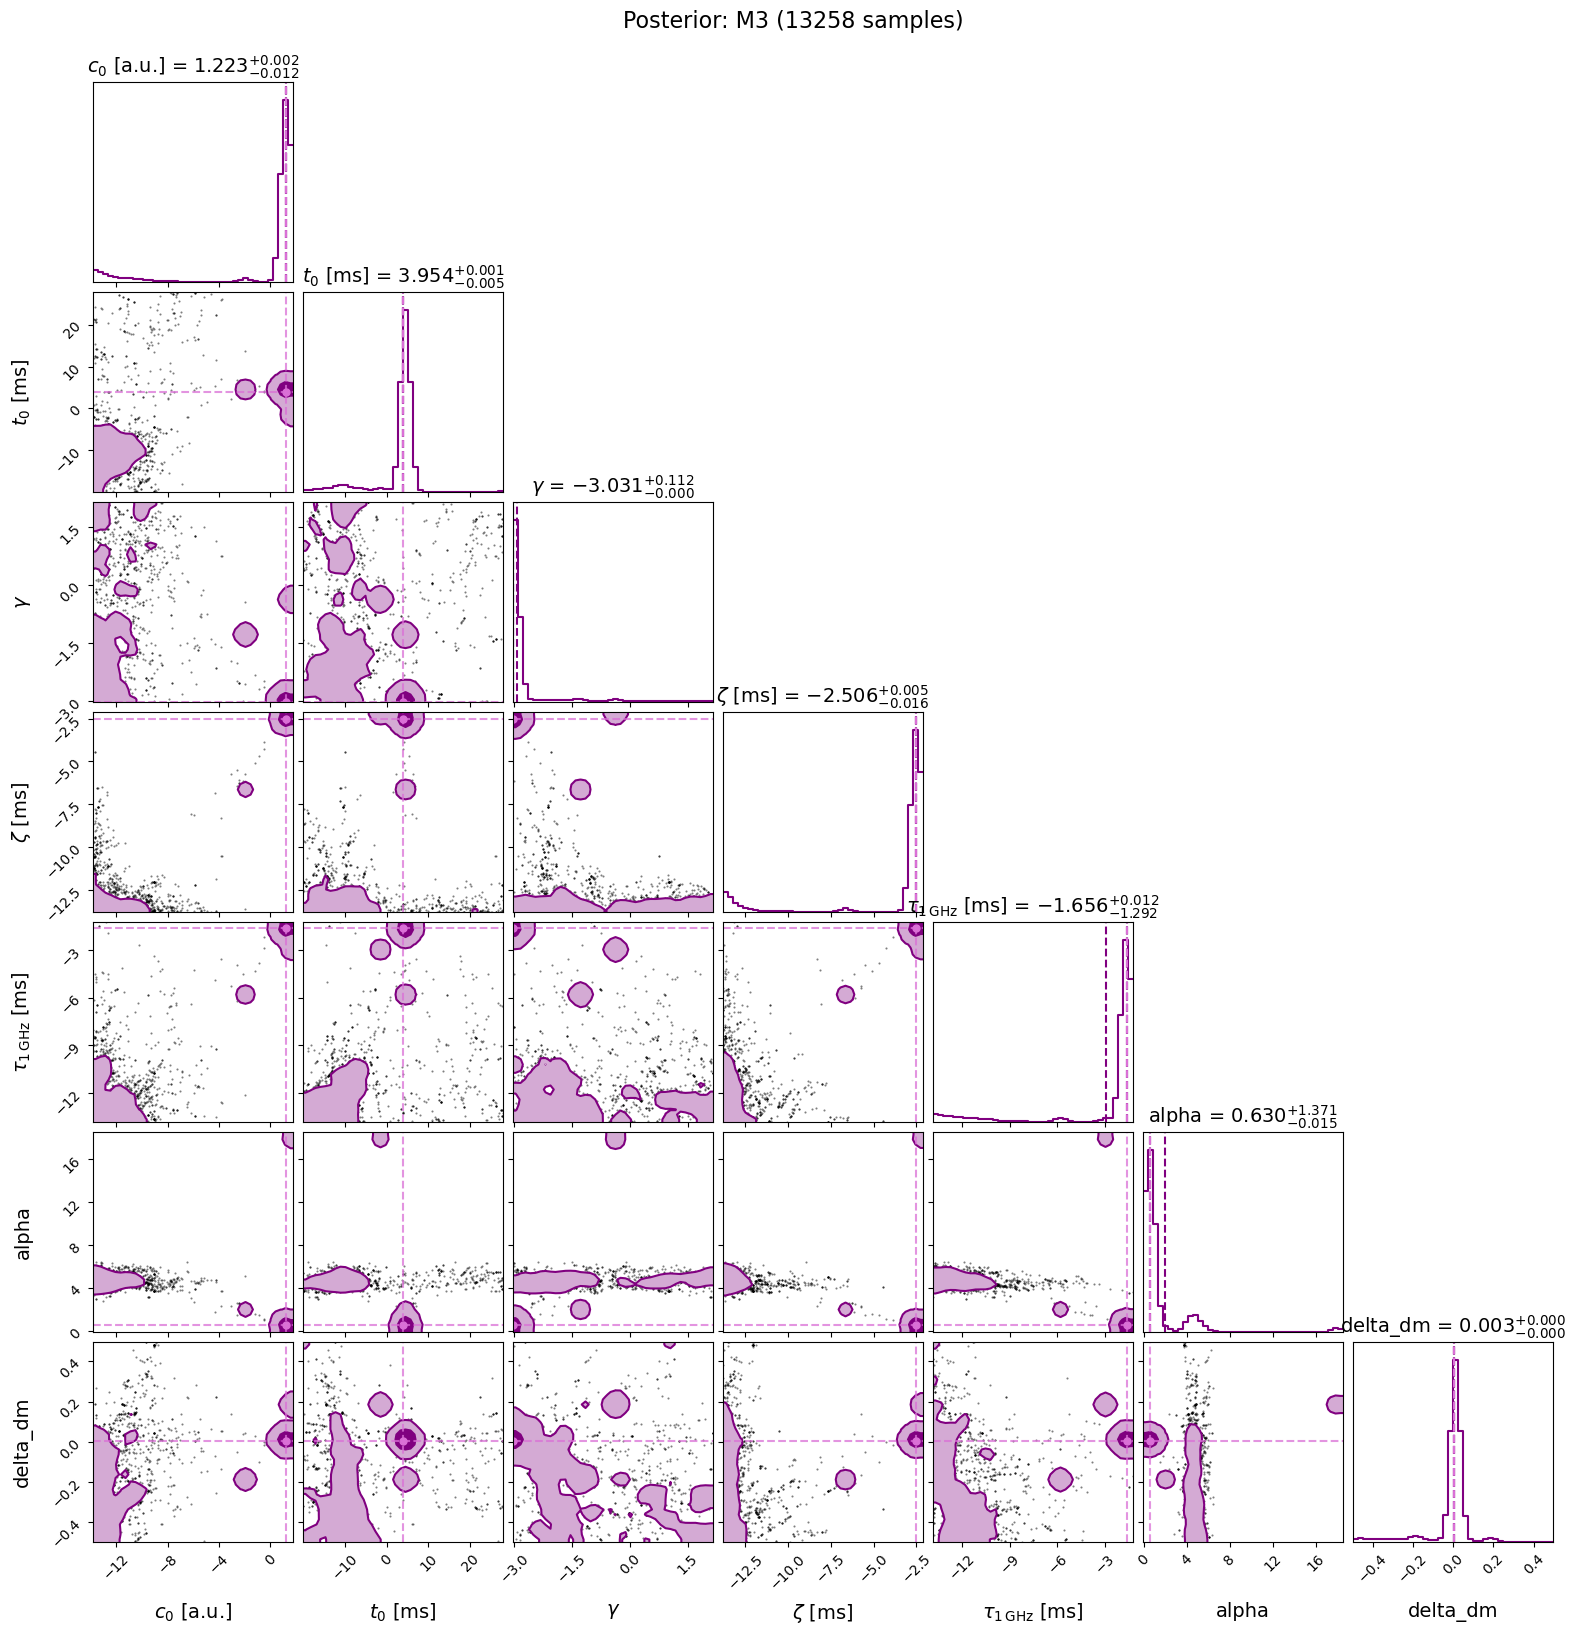

In [11]:
# Generate corner plot
from scat_analysis.burstfit_corner import make_beautiful_corner, get_clean_samples

# Get clean samples (with burn-in removed)
clean_samples = get_clean_samples(sampler, param_names, verbose=True)

# Create corner plot
fig = make_beautiful_corner(
    clean_samples, 
    param_names, 
    best_params=best_params,
    title=f'Posterior: {results["best_key"]} ({clean_samples.shape[0]} samples)'
)

# Save
output_dir = config.path.parent
corner_path = output_dir / f'{config.path.stem}_corner.png'
fig.savefig(corner_path, dpi=150, bbox_inches='tight')
print(f'[OK] Corner plot saved to {corner_path}')

## Analysis Complete

### Output Files
- Diagnostic plots: `{output_dir}/*.png`
- MCMC chains: `{output_dir}/chains.npy`
- Corner plot: `{output_dir}/corner_plot.png`